In [15]:
import logging
import random
from typing import Any

import numpy as np
import timm
import torch
import torchvision
from timm.models.swin_transformer_v2_cr import init_weights
from torch.utils.data import WeightedRandomSampler, BatchSampler
from torchvision.models import VisionTransformer

from hw2.utils.lr_scheduler import warmup
from sklearn import metrics

import wandb
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.axes import Axes
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision.transforms import v2

import hw2.utils.recursive_reload
%reload hw2
from hw2 import PROJECT_ROOT
from hw2.data.cifar100_lt import CIFAR100LT
from hw2.utils import find_mean_and_stddev, train_on_cifar, validate_on_cifar
from hw2.visualization import visualize_images
from hw2.models.inception_v3 import get_inception_v3, get_inception_v3_transform

reloaded module: hw2


In [2]:
dataset = CIFAR100LT(root=PROJECT_ROOT / "data", train=True, imb_type='exp', imb_factor=0.01, download=True, transform=None)
dataset

Files already downloaded and verified


Dataset CIFAR100LT
    Number of datapoints: 10899
    Root location: D:\Code\CISC3027\hw2\data
    Split: Train

In [3]:
dataset.class_to_idx

{'apple': 0,
 'aquarium_fish': 1,
 'baby': 2,
 'bear': 3,
 'beaver': 4,
 'bed': 5,
 'bee': 6,
 'beetle': 7,
 'bicycle': 8,
 'bottle': 9,
 'bowl': 10,
 'boy': 11,
 'bridge': 12,
 'bus': 13,
 'butterfly': 14,
 'camel': 15,
 'can': 16,
 'castle': 17,
 'caterpillar': 18,
 'cattle': 19,
 'chair': 20,
 'chimpanzee': 21,
 'clock': 22,
 'cloud': 23,
 'cockroach': 24,
 'couch': 25,
 'crab': 26,
 'crocodile': 27,
 'cup': 28,
 'dinosaur': 29,
 'dolphin': 30,
 'elephant': 31,
 'flatfish': 32,
 'forest': 33,
 'fox': 34,
 'girl': 35,
 'hamster': 36,
 'house': 37,
 'kangaroo': 38,
 'keyboard': 39,
 'lamp': 40,
 'lawn_mower': 41,
 'leopard': 42,
 'lion': 43,
 'lizard': 44,
 'lobster': 45,
 'man': 46,
 'maple_tree': 47,
 'motorcycle': 48,
 'mountain': 49,
 'mouse': 50,
 'mushroom': 51,
 'oak_tree': 52,
 'orange': 53,
 'orchid': 54,
 'otter': 55,
 'palm_tree': 56,
 'pear': 57,
 'pickup_truck': 58,
 'pine_tree': 59,
 'plain': 60,
 'plate': 61,
 'poppy': 62,
 'porcupine': 63,
 'possum': 64,
 'rabbit': 65,

In [4]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, np.int64(0))

In [5]:
samples = dataset.get_superclass_sample()

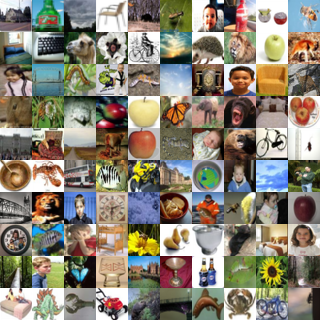

In [6]:
rand_images = random.choices(dataset, k=100)
visualize_images([img for img, _target in rand_images], show=False)

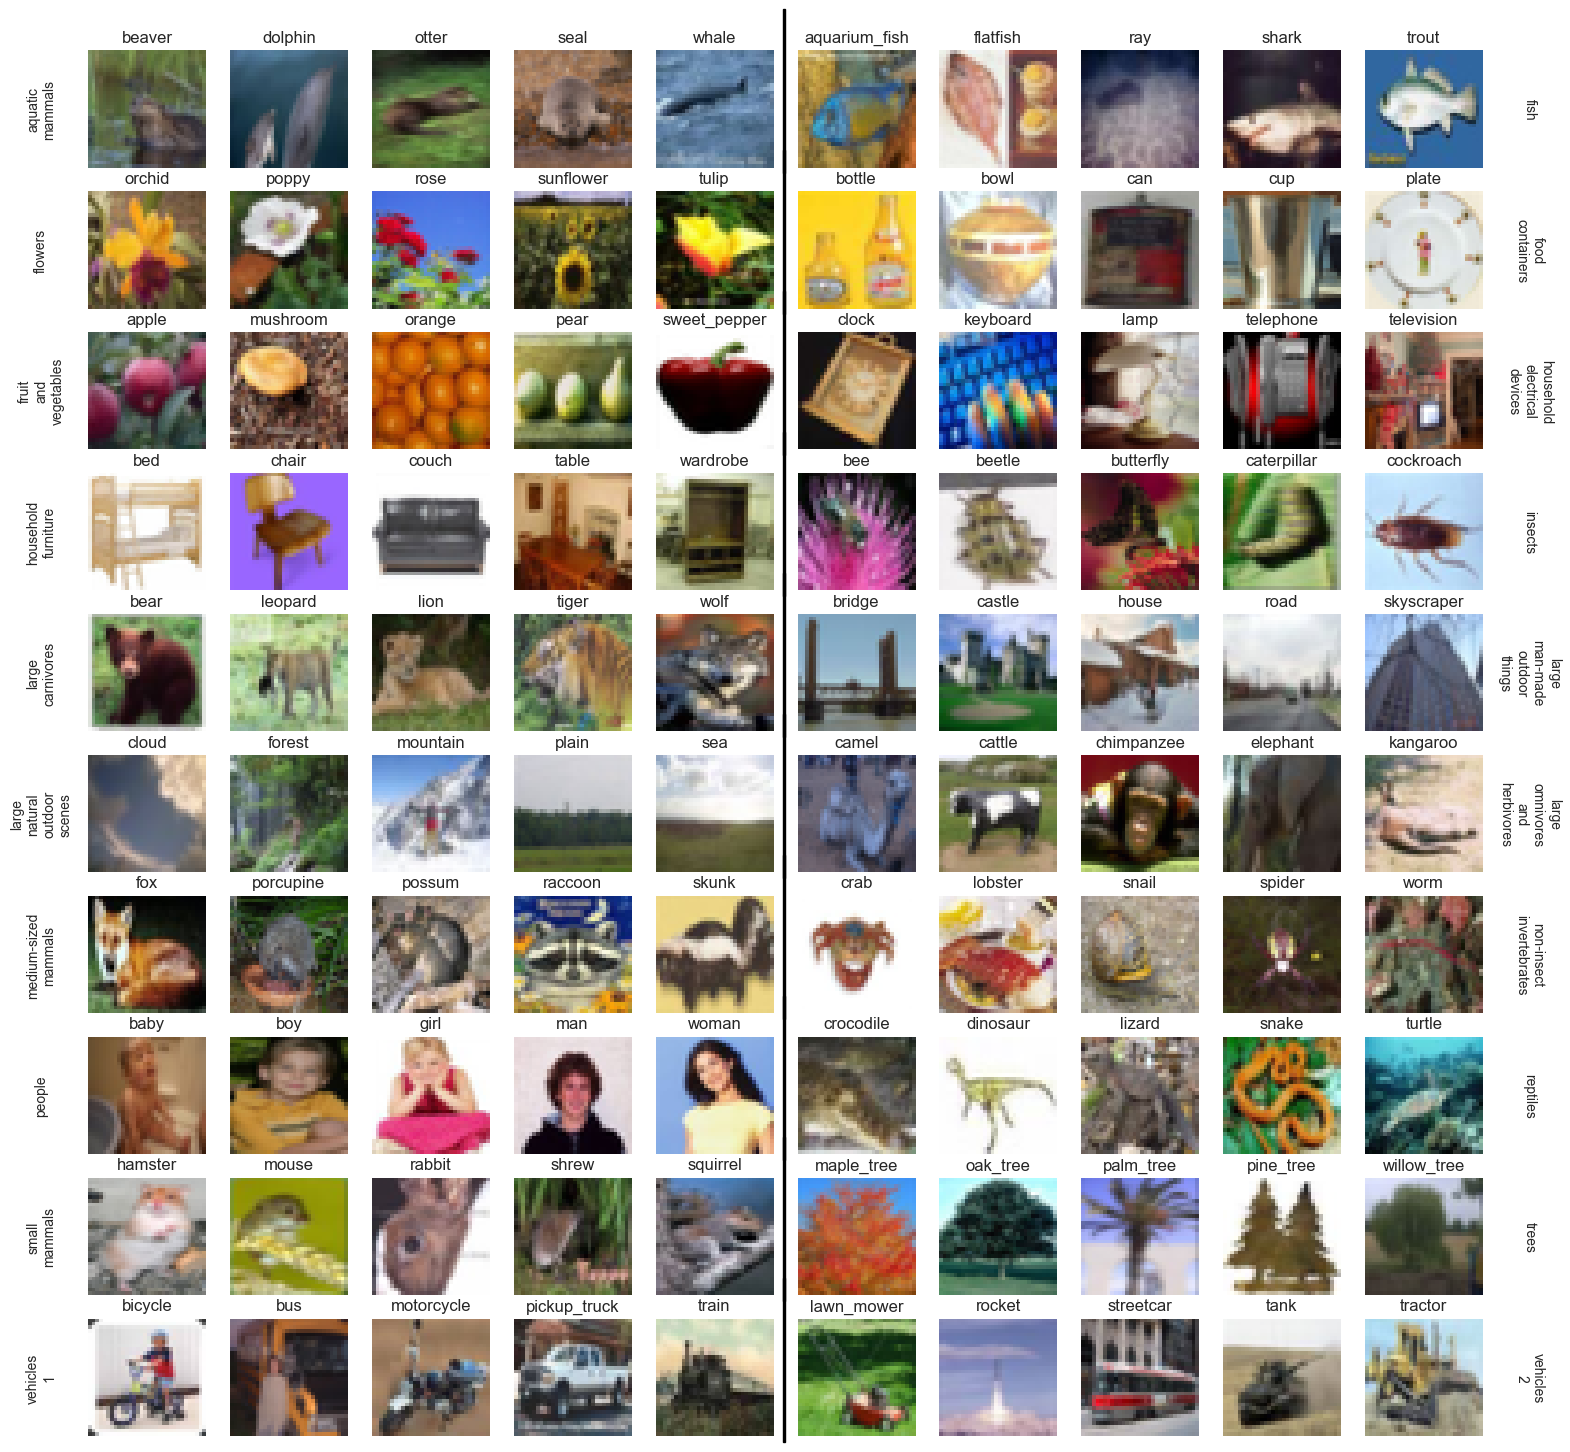

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(18, 18))


for i, (cls, superclass_samples) in enumerate(samples.items()):
    for j, img in enumerate(superclass_samples):
        axes[i // 2, j + 5 * (i % 2)].imshow(img)
        axes[i // 2, j + 5 * (i % 2)].axis("off")
        axes[i // 2, j + 5 * (i % 2)].set_title(dataset.superclass_to_class[cls][j])

    # Format the superclass name to split words into separate lines, because the graph has overlapping text without this
    formatted_superclass = "\n".join(cls.split())

    # Add superclass labels
    if i % 2 == 0:  # Left side
        axes[i // 2, 0].annotate(
            formatted_superclass,
            xy=(-0.4, 0.5),
            xycoords="axes fraction",
            fontsize=10,
            ha="center",
            va="center",
            rotation=90,
            wrap=True,
        )
    else:  # Right side
        axes[i // 2, 9].annotate(
            formatted_superclass,
            xy=(1.4, 0.5),
            xycoords="axes fraction",
            fontsize=10,
            ha="center",
            va="center",
            rotation=270,
            wrap=True,
        )

for ax_row in axes:
    ax_row[4].add_patch(
        patches.Rectangle(
            xy=(1.08, -0.05),
            width=0.02,
            height=1.4,
            transform=ax_row[4].transAxes,
            color="black",
            clip_on=False,
        )
    )

# plt.savefig(PROJECT_ROOT / "artifacts" / "CIFAR100_grid_visualization.svg")
# plt.show()

In [8]:
type(axes), type(axes[0]), type(axes[0, 0])

(numpy.ndarray, numpy.ndarray, matplotlib.axes._axes.Axes)

In [9]:
find_mean_and_stddev(dataset)

PIL images are supported, but you may want to convert them to float tensors for actual use.


((133.46295166015625, 125.7606201171875, 112.79025268554688),
 (68.33049774169922, 66.579345703125, 70.85379028320312))

In [10]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
dataset = CIFAR100LT(root=PROJECT_ROOT / "data", train=True, imb_type='exp', imb_factor=0.01, download=True, transform=transform)

Files already downloaded and verified


In [11]:
find_mean_and_stddev(dataset)

((0.5226040482521057, 0.4923234283924103, 0.44224125146865845),
 (0.2684156596660614, 0.2616777718067169, 0.2784672975540161))

In [12]:
from functools import partial

tuple(map(lambda x: tuple(map(partial(round, ndigits=4), x)), find_mean_and_stddev(dataset)))

((0.5226, 0.4923, 0.4422), (0.2684, 0.2617, 0.2785))

In [22]:
from hw2.models.cnn_basic import LeNet5

# model = LeNet5(channels=3, n_classes=100)
# transform = CIFAR100LT.basic_train_transform

model = torchvision.models.resnet18(num_classes=100)
transform = CIFAR100LT.basic_train_transform

# model = torchvision.models.resnet50(num_classes=100)
# transform = CIFAR100LT.basic_train_transform

# Too large for 3060
# model = get_inception_v3(num_classes=100)
# transform = get_inception_v3_transform()

# model = torchvision.models.googlenet(num_classes=100, init_weights=True)
# transform = v2.Compose([
#     v2.ToImage(),
#     v2.Resize((224, 224)),
#     v2.ToDtype(torch.float32, scale=True),
# ])

dataset = CIFAR100LT(root=PROJECT_ROOT / "data", train=True, imb_type='exp', imb_factor=0.01, download=True, transform=transform)

Files already downloaded and verified
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weig

In [23]:
config = {
    "model_type": "CNN",
    "_model_auto": model.__class__.__name__,
    "model": "ResNet-50",
    "epochs": 70,
    "learning_rate": 0.005,
    "batch_size": 64,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "dataset": "CIFAR100LT",
    "weight_decay": 0.1,
}

tags = ["weighted", "smoothing"]

if config["dataset"] == "CIFAR100LT":
    class_weights = 1 / torch.tensor(dataset.img_num_per_cls, device=config["device"])
    sample_weights = [class_weights[target] for target in dataset.targets]
    sampler = BatchSampler(WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True), batch_size=config["batch_size"], drop_last=False)
else:
    class_weights = None
    sampler = None

criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), weight_decay=config["weight_decay"], lr=config["learning_rate"])

# Separate parameters with and without weight decay
params_with_decay = []
params_without_decay = []
for name, param in model.named_parameters():
    if "bias" in name or "bn" in name:  # Example: Skip bias and batch norm params
        params_without_decay.append(param)
    else:
        params_with_decay.append(param)

# Define the optimizer
optimizer = optim.AdamW([
    {"params": params_with_decay, "weight_decay": config["weight_decay"]},
    {"params": params_without_decay, "weight_decay": 0.0},
], lr=config["learning_rate"])


# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"], eta_min=0)
scheduler = lr_scheduler.StepLR(optimizer, 15, 0.2)
scheduler = warmup(scheduler)

config.update({
    "optimizer": optimizer.__class__.__name__,
    "lr_scheduler": scheduler.__class__.__name__,
})

run = wandb.init(
    project="CISC3027 hw3",
    group=None,
    job_type="train",
    config=config,
    dir=PROJECT_ROOT / "wandb",
    tags=tags,
)

logging.basicConfig(level=logging.INFO, force=True)

# train
train_on_cifar(model, optimizer, criterion, scheduler, transform, config["epochs"], config["device"], log_run=True, cifar_dataset=config["dataset"], n_test_samples=10000, batch_sampler=sampler, label_smoothing=0.05)


Files already downloaded and verified
Files already downloaded and verified


INFO:hw2.utils:Epoch 0, Batch 0, Loss: 4.7820
INFO:hw2.utils:Epoch 0, Batch 7, Loss: 5.0737
INFO:hw2.utils:Epoch 0, Batch 14, Loss: 4.4679
INFO:hw2.utils:Epoch 0, Batch 21, Loss: 4.6240
INFO:hw2.utils:Epoch 0, Batch 28, Loss: 4.4605
INFO:hw2.utils:Epoch 0, Batch 35, Loss: 4.3791
INFO:hw2.utils:Epoch 0, Batch 42, Loss: 4.0604
INFO:hw2.utils:Epoch 0, Batch 49, Loss: 4.2796
INFO:hw2.utils:Epoch 0, Batch 56, Loss: 4.2102
INFO:hw2.utils:Epoch 0, Batch 63, Loss: 4.0397
INFO:hw2.utils:Epoch 0, Batch 70, Loss: 4.0842
INFO:hw2.utils:Epoch 0, Batch 77, Loss: 4.1548
INFO:hw2.utils:Epoch 0, Batch 84, Loss: 4.1447
INFO:hw2.utils:Epoch 0, Batch 91, Loss: 4.1817
INFO:hw2.utils:Epoch 0, Batch 98, Loss: 3.9820
INFO:hw2.utils:Epoch 0, Batch 105, Loss: 4.0820
INFO:hw2.utils:Epoch 0, Batch 112, Loss: 3.9395
INFO:hw2.utils:Epoch 0, Batch 119, Loss: 4.1330
INFO:hw2.utils:Epoch 0, Batch 126, Loss: 3.8183
INFO:hw2.utils:Epoch 0, Batch 133, Loss: 4.0487
INFO:hw2.utils:Epoch 0, Batch 140, Loss: 3.8131
INFO:hw2.

(6.09011397180678, 0.1904)

In [29]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.02
    lr: 0.02
    maximize: False
    weight_decay: 0.1
)

In [17]:
run.finish()

batch,▁▄█▄▇▃▅▁▄▅▄▅▄█▁▅▂▂▄▇▆█▂▆▂▅▆▂▅▂█▄▃▁▂▂▂▇▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
test/accuracy,▁▁▂▂▃▄▆▅▆▆▇█▇▇▇▇████████████████████████
test/loss,▂▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▆▆▆▇▇▇▇▇█▇████████
train/accuracy,▁▁▂▂▂▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██████████████████
train/loss,▇██▇▇█▇▆▅▆▅▄▃▂▃▂▂▃▂▂▂▃▂▂▂▂▁▂▁▁▂▁▁▂▂▁▁▁▁▁
train/lr,▅▆████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,70
epoch,70
test/accuracy,0.193
test/loss,6.63761


In [27]:
from pprint import pp
results = validate_on_cifar(model, criterion, CIFAR100LT.basic_test_transform, config["device"], additional_metrics=[partial(metrics.classification_report, digits=4, zero_division=0)], cifar_dataset="CIFAR100LT")
print(results["classification_report"])

Files already downloaded and verified


INFO:hw2.utils:Validation loss: 6.600895978227446, accuracy: 0.1902, classification_report:               precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           7     1.0000    1.0000    1.0000         1
          12     0.0000    0.0000    0.0000         0
          14     0.0000    0.0000    0.0000         2
          15     0.0000    0.0000    0.0000         0
          16     0.0000    0.0000    0.0000         1
          21     0.0000    0.0000    0.0000         0
          25     0.0000    0.0000    0.0000         0
          26     0.0000    0.0000    0.0000         0
          27     0.0000    0.0000    0.0000         1
          29     0.0000    0.0000    0.0000         0
          30     1.0000    1.0000    1.0000         1
          38     0.0000    0.0000    0.0000         0
          42     0.0000    0.0000    0.0000         1
          50     0.0000    0.0000    0.0000         1
          51     0.0000    0.0000    0.0000

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           7     1.0000    1.0000    1.0000         1
          12     0.0000    0.0000    0.0000         0
          14     0.0000    0.0000    0.0000         2
          15     0.0000    0.0000    0.0000         0
          16     0.0000    0.0000    0.0000         1
          21     0.0000    0.0000    0.0000         0
          25     0.0000    0.0000    0.0000         0
          26     0.0000    0.0000    0.0000         0
          27     0.0000    0.0000    0.0000         1
          29     0.0000    0.0000    0.0000         0
          30     1.0000    1.0000    1.0000         1
          38     0.0000    0.0000    0.0000         0
          42     0.0000    0.0000    0.0000         1
          50     0.0000    0.0000    0.0000         1
          51     0.0000    0.0000    0.0000         1
          54     0.0000    0.0000    0.0000         0
          55     0.0000    

In [19]:
torch.save(model.state_dict(), PROJECT_ROOT / "models" / "cifar100lt" / f"resnet50_{results["accuracy"]}_warmup.pth")

In [40]:
model = timm.create_model("timm/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k", pretrained=True)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
model.head = torch.nn.Linear(in_features=model.head.in_features, out_features=100)
# 20 blocks in total
# Freeze all layers except the head and the last 2 blocks
for name, param in model.named_parameters():
    # print(name)
    if "head" in name or name.startswith("blocks.19") or "fc_norm" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k)
INFO:timm.models._hub:[timm/vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [41]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
epochs = 320
learning_rate = 0.001
batch_size = 64

# class_weights = 1 / torch.tensor(dataset.img_num_per_cls)
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# sample_weights = [class_weights[target] for target in dataset.targets]
# sampler = BatchSampler(WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True), batch_size=64, drop_last=False)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), weight_decay=0.1)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [40]:
run = wandb.init(
    project="CISC3027 hw3",
    group=None,
    job_type="train",
    config={
        "model_type": "ViT",
        "model": "vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k",
        "epochs": epochs,
        "optimizer": optimizer.__class__.__name__,
        "lr_scheduler": scheduler.__class__.__name__,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "device": device,
        "dataset": "CIFAR100LT"
    }
)

logging.basicConfig(level=logging.INFO, force=True)

# train
train_on_cifar(model, optimizer, criterion, scheduler, transforms, epochs, device, log_run=True, cifar_dataset="CIFAR100LT", n_test_samples=10000)

NameError: name 'epochs' is not defined

In [43]:
torch.save(model.state_dict(), PROJECT_ROOT / "models" / "cifar100lt" / f"vit_{results["accuracy"]}_epochs8.5.pth")

In [44]:
results

{'loss': 34.716773986816406,
 'accuracy': 0.1468,
 'classification_report': '              precision    recall  f1-score   support\n\n           0     0.2042    0.6800    0.3141       100\n           1     0.1355    0.6300    0.2230       100\n           2     0.1029    0.4300    0.1660       100\n           3     0.0624    0.2900    0.1027       100\n           4     0.0518    0.2900    0.0879       100\n           5     0.0741    0.3400    0.1216       100\n           6     0.1036    0.4000    0.1646       100\n           7     0.0860    0.3700    0.1396       100\n           8     0.0990    0.3800    0.1570       100\n           9     0.1390    0.3600    0.2006       100\n          10     0.0391    0.1100    0.0577       100\n          11     0.1244    0.2400    0.1638       100\n          12     0.1144    0.3900    0.1769       100\n          13     0.0796    0.2300    0.1183       100\n          14     0.0625    0.1400    0.0864       100\n          15     0.0729    0.1800    0.10